In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
!wget -q https://www.dropbox.com/s/91nylpfufphsure/21-137823-0022.flac

In [ ]:
!ls

21-137823-0022.flac  drive  sample_data


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os 
import shutil
import tensorflow as tf 
import librosa
from string import ascii_lowercase
 

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/ASR/Train.csv')

In [ ]:
train.head(10)

,ID,up_votes,down_votes,age,gender,transcription
0,002e50c29ac2890c7cb3b3d63dcbe512bc6850de206ca8...,2,0,NaN,NaN,Malicka
1,0031672b4484f963c8a07babe6f713dd559539d44140e8...,2,0,twenties,female,Ecole Elementaire Pikine Nord
2,00362ccc6b48d3ea225e12ddf8a06a9d582cccc03b0353...,2,0,twenties,male,Cimetière de Cambérène
3,0042cdb4d4a015cddacc26d88faffdd714b7a27213d2b3...,2,0,twenties,male,Tournalou Boune
4,00439f02fa8f0dade934bdb317199b71662e9396f6bb81...,2,0,twenties,male,Pharmacie Golf Sud
5,00449100b205f8244174936b580e4084968ab7bbd738d0...,2,0,twenties,female,Gare Feroviére de Dakar
6,004bb970ff5217dc663cd9d69cf6dccc8b4197062ad48d...,2,0,teens,male,Ouakam
7,004bc77cc17a10c3964932a6e5acaa7494023d8fca26ac...,2,0,NaN,NaN,Mangazin
8,004eb9d3868f15c4d909147ef19b8a7b02140f481c1829...,3,0,twenties,male,Mairie de la ville de Dakar
9,005cea38ff6e71a7d1047aba774790ad04336b73fed6c0...,2,1,twenties,male,Collège Sacré Cœur


In [ ]:
transcription = train['transcription']

In [ ]:
def get_alphabet():
  uniques = set()
  for line in transcription:
    uniques.update(w.lower() for w in line)

  return sorted(uniques)

In [ ]:
print("All alphabet ",get_alphabet())
print("The length of our alphabet {}".format(len(get_alphabet())))

All alphabet  [' ', '"', "'", '(', ')', ',', '-', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'â', 'ç', 'è', 'é', 'ë', 'î', 'ô', 'œ', '’']
The length of our alphabet 42


In [ ]:
class ASR(tf.keras.Model):
    def __init__(self, filters, kernel_size, conv_stride, conv_border,n_lstm_units, n_dense_units):
      super(ASR, self).__init__()
      self.conv_layer = tf.keras.layers.Conv1D(filters,
                                                 kernel_size,
                                                 strides=conv_stride,
                                                 padding=conv_border, 
                                                activation='relu') 
      self.lstm_layer = tf.keras.layers.LSTM(n_lstm_units,
                                               return_sequences=True,
                                               activation='tanh')
      self.lstm_layer_back = tf.keras.layers.LSTM(n_lstm_units,
                                                    return_sequences=True,
                                                    go_backwards=True,
                                                    activation='tanh')
      self.blstm_layer =tf.keras.layers.Bidirectional(self.lstm_layer,backward_layer=self.lstm_layer_back)
      self.dense_layer = tf.keras.layers.Dense(n_dense_units)

    def call(self, x):
      x = self.conv_layer(x)
      x = self.blstm_layer(x)
      x = self.dense_layer(x)
      return x

In [ ]:
def compute_ctc_loss (logits , labels , logit_length , label_length):


  return tf.nn.ctc_loss (labels=labels, 
                         logits=logits, 
                         label_length=label_length,
                         logit_length=logit_length,
                         logits_time_major=False,
                         unique=None,
                         blank_index=1,
                         name=None)

In [ ]:
 
temp_count = 0
audio_lengths = []
for i, (dirpath, dirnames, filenames) in enumerate(os.walk(train_path)):
        print(dirpath)
        for j,f in enumerate(filenames):
            temp_count +=1
            print(temp_count,f)
            if temp_count%10==0:
                y1, sr1 = librosa.load(dirpath+'/'+f)
                print(y1.shape,sr1)
                audio_lengths.append(y1.shape[0])


NameError: ignored

In [ ]:
aud_len = np.asarray(audio_lengths)

# print the mean
print(aud_len.mean())

#get the min and max
aud_len[aud_len.argmin()],aud_len[aud_len.argmax()]



66524.45359281437


(25931, 156644)

In [ ]:
def pad_audio(data, fs, target):
    # target number of samples
    N_tar = int(fs * target)
    # number of zero samples to append
    shape = data.shape
    if shape[0]> N_tar:
        return data[:N_tar]
    # Create the target shape    
    N_pad = N_tar - shape[0]
    print("Padding with %s seconds of silence" % str(N_pad/fs) )
    new_shape = (N_pad,) + shape[1:]
    # Stack only if there is something to append    
    if shape[0] > 0:                
        if len(shape) > 1:
            return np.vstack((np.zeros(new_shape),
                              data))
        else:
            return np.hstack((np.zeros(new_shape),
                              data))
    else:
        return data

In [ ]:
def create_spectrogram(signals):
    stfts = tf.signal.stft(signals, frame_length=256,frame_step=80 , fft_length=256 )
    spectrograms = tf.math.pow(tf.abs(stfts), 0.5)
    return spectrograms

In [ ]:
def generate_input_from_audio_file(path_to_audio_file , resample_to=8000):
  signal , sample_rate= librosa.core.load(path_to_audio_file) 
  signal = pad_audio(signal , sample_rate , 6)

  if signal.shape[0]==2:
    signal = np.mean(signal , axis=0)
  signal_resampled = librosa.core.resample(signal , sample_rate , resample_to)

  X =  create_spectrogram(signal_resampled)

  #Normalisation 

  means = tf.math.reduce_mean(X , 1, keepdims=True)
  stddevs = tf.math.reduce_std(X , 1 , keepdims=True)
  X=tf.divide(tf.subtract(X, means ) , stddevs)
  X = tf.expand_dims(X , axis=0)

  return X 


Make the label from the target Text

In [ ]:
def generate_target_output_from_text(target_text):

  #space_token = ' '
  #end_token = '>'
  #blank_token = '%'
  #pp = ['é', 'è', 'œ','ù']

  alphabet = get_alphabet()

  char_to_index = {}

  for idx , char in enumerate(alphabet):
    char_to_index[char] =idx

  y =[]

  for char in target_text:
    y.append(char_to_index[char]) 

  y=tf.expand_dims(tf.convert_to_tensor(y) , axis=0)

  return y

In [ ]:
x , sr = librosa.load('b.mp3')

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [ ]:
print(x.shape)
print(sr)

(68267,)
22050


In [ ]:
import matplotlib.pyplot as plt
import librosa.display
from IPython.display import  Audio

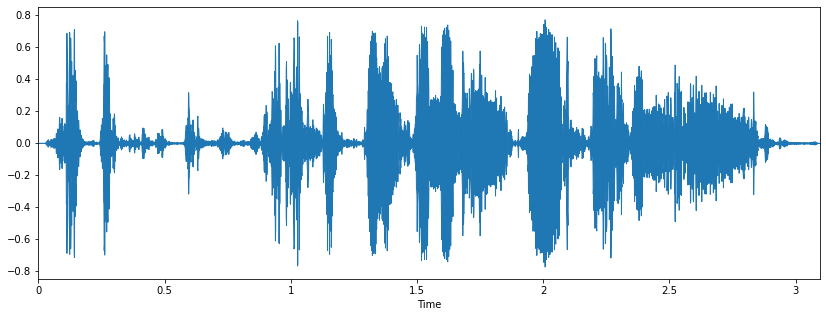

In [ ]:
plt.figure(figsize=(14,5))
librosa.display.waveplot(x , sr=sr)

In [ ]:
Audio('b.mp3')

In [ ]:
sample_call = 'b.mp3'
transcript = 'école élèmentaire pikine nord'

In [ ]:
X = generate_input_from_audio_file(sample_call)
#X = tf.expand_dims(X , axis=0)
y= generate_target_output_from_text(transcript)
#y=tf.expand_dims(tf.convert_to_tensor(y) , axis=0)

print(X.shape)
print(y.shape)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 2.9039909297052153 seconds of silence
(1, 597, 129)
(1, 29)


>Here we create the dataset for training 

In [ ]:
data={
    "inputs":[],
    "targets":[]
}

In [ ]:
train_path = os.path.join('/content/drive/MyDrive/ASR/train/')

In [ ]:
for i in range(100):
  file = train_path+os.listdir(train_path)[i]
  X = generate_input_from_audio_file(file)
  y= generate_target_output_from_text(transcription[i].lower())
  data["inputs"].append(X)
  data["targets"].append(y)



/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 3.8159637188208615 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 2.9759637188208616 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 1.1759637188208616 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 3.215963718820862 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 3.5039909297052154 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 2.0159637188208617 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 2.735963718820862 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 3.0959637188208617 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 3.263990929705215 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 3.5039909297052154 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 4.1039909297052155 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 3.9359637188208616 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 3.3359637188208615 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 3.0959637188208617 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 0.5759637188208617 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 2.0159637188208617 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 1.8239909297052155 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 3.5759637188208617 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 3.3359637188208615 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 3.263990929705215 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 2.3039909297052152 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 2.3039909297052152 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 3.7439909297052156 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 3.3359637188208615 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 4.223990929705216 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 3.0959637188208617 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 4.175963718820862 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 4.295963718820862 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 3.695963718820862 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 3.0239909297052154 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 2.9759637188208616 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 3.6239909297052155 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 4.1039909297052155 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 2.5439909297052155 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 3.0239909297052154 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 3.1439909297052155 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 4.1039909297052155 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 2.6639909297052156 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 3.6239909297052155 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 3.263990929705215 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 4.343990929705216 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 4.463990929705216 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 3.0959637188208617 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 4.223990929705216 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 3.4559637188208616 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 3.7439909297052156 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 4.295963718820862 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 3.695963718820862 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 3.263990929705215 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 3.9359637188208616 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 2.3039909297052152 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 4.223990929705216 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 3.3839909297052153 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 3.0239909297052154 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 3.0239909297052154 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 3.3839909297052153 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 3.5039909297052154 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 3.5039909297052154 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 3.5759637188208617 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 2.9039909297052153 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 2.735963718820862 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 2.9039909297052153 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 3.7439909297052156 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 3.3359637188208615 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 2.735963718820862 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 2.9039909297052153 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 3.7439909297052156 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 4.175963718820862 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 3.215963718820862 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 3.695963718820862 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 4.343990929705216 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 3.9359637188208616 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 3.215963718820862 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 3.9359637188208616 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 3.7439909297052156 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 4.175963718820862 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 2.8559637188208615 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 3.9359637188208616 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 3.695963718820862 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 3.5759637188208617 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 4.055963718820862 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 3.5759637188208617 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 3.4559637188208616 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 2.4239909297052153 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 3.3359637188208615 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 3.1439909297052155 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 3.5759637188208617 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 3.9839909297052154 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 4.1039909297052155 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 3.215963718820862 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 2.9039909297052153 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 3.6239909297052155 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 3.3839909297052153 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 3.5039909297052154 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 4.1039909297052155 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 3.215963718820862 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 4.343990929705216 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 4.223990929705216 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 3.5039909297052154 seconds of silence


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Padding with 4.415963718820862 seconds of silence


In [ ]:
maxx = []

In [ ]:
for i in range(len(data["targets"])):
  maxx.append(data["targets"][1].shape[1])

In [ ]:
mm = []

In [ ]:
for i in range(len(data["targets"])):

  y =tf.keras.preprocessing.sequence.pad_sequences(data["targets"][i], maxlen=29 ,  padding='post')

  mm.append(y)

In [ ]:
mm[:2]

[array([[19,  7, 18, 15,  9, 17,  7,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]], dtype=int32),
 array([[11,  9, 21, 18, 11,  0, 11, 18, 11, 19, 11, 20, 26,  7, 15, 24,
         11,  0, 22, 15, 17, 15, 20, 11,  0, 20, 21, 24, 10]], dtype=int32)]

In [ ]:
Y.shape

(1, 29)

In [ ]:
data["inputs"][0].shape

TensorShape([1, 597, 129])

In [ ]:
data["targets"][3].shape

TensorShape([1, 15])

In [ ]:
dataset = tf.data.Dataset.from_generator((data["inputs"][:400], mm[:400]) , output_types=tf.float32)
dataset = dataset.batch(4, drop_remainder=True) 

TypeError: ignored

In [ ]:

for step ,(x,y) in enumerate(dataset):
  print(x)
  break

tf.Tensor(
[[[21 27  7 ...  0  0  0]]

 [[25 26  7 ...  0  0  0]]

 [[13  7 24 ...  0  0  0]]

 ...

 [[19  7 20 ...  0  0  0]]

 [[25 26  7 ...  0  0  0]]

 [[ 9  7 19 ...  0  0  0]]], shape=(64, 1, 29), dtype=int32)


In [ ]:
data["targets"][0]

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[19,  7, 18, 15,  9, 17,  7]], dtype=int32)>

In [ ]:
model =  ASR(256 , 5,5,'valid' ,256,42)



optimizer =  tf.keras.optimizers.Adam()


for step in range(10):
  with tf.GradientTape() as tape :
    logits = model(X)
    labels =y
    logits_length = [logits.shape[1]*logits.shape[0]]
    labels_length = [labels.shape[1]*labels.shape[0]]
    loss = compute_ctc_loss(logits , labels , logit_length = logits_length , label_length=labels_length)
    loss =  tf.reduce_mean(loss)
  grads = tape.gradient(loss , model.trainable_variables)
  optimizer.apply_gradients(zip(grads , model.trainable_variables))

  print('Epochs {}, Loss : {}'.format(step , loss))
  


Epochs 0, Loss : nan
Epochs 1, Loss : nan
Epochs 2, Loss : nan
Epochs 3, Loss : nan
Epochs 4, Loss : nan
Epochs 5, Loss : nan
Epochs 6, Loss : nan
Epochs 7, Loss : nan
Epochs 8, Loss : nan
Epochs 9, Loss : nan


In [ ]:
print("Hello")

Hello


In [ ]:
#Getting the ctc output look

ctc_output = model(X)
ctc_output = tf.nn.log_softmax(ctc_output) 
#greedy decoding 
#space_token = ' '
#end_token='>'
#blank_token='%'

alphabet = get_alphabet()
output_text = ''

for timestep in ctc_output[0]:
  output_text +=alphabet[tf.math.argmax(timestep)] 


print(output_text)

In [ ]:
#Getting the ctc output look
def predict(file):
  ctc_output = model(file)
  ctc_output = tf.nn.log_softmax(ctc_output) 
#greedy decoding 


 # space_token = ' '
  #end_token='>'
  #blank_token='%'
  alphabet = get_alphabet()
  output_text = ''

  for timestep in ctc_output[0]:

    output_text +=alphabet[tf.math.argmax(timestep)] 

  return output_text

In [ ]:
train_path = os.path.join('/content/drive/MyDrive/ASR/train/')

In [ ]:
track = train_path+os.listdir(train_path)[1]

In [ ]:
Audio(track)

In [ ]:
def preprocessing(file):

  X= generate_input_from_audio_file(file)
  return X

In [ ]:
XX= preprocessing(track)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [ ]:
predict(XX)

'ca""m"""" """""""""""""""""""""""""""""""""""""""""""""a""""'

In [ ]:
testa=[]

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/ASR/Test.csv')

In [ ]:
test.head()

,ID,up_votes,down_votes,age,gender
0,00416cff4f818d3dfd99c9178ff0e268e7575500c8baa5...,2,0,twenties,male
1,00891ba561e80e135f9d12b9fa1347f0a2560998f7ea16...,2,0,twenties,male
2,00a508027ed4edf0bd3db79f45f4ed6e1b89fba6482c10...,2,0,twenties,male
3,00ac13cd0d93e35c1ff672cc106ad94d1ea9b93fcf049a...,2,0,twenties,female
4,00c2d5baf4719bf01b990a8924e99bda043cd462147193...,2,0,twenties,male


In [ ]:
test_path = os.path.join('/content/drive/MyDrive/test/')

In [ ]:
len(os.listdir(test_path))

1564

In [ ]:
len(test)

1590

In [ ]:
for i in range(1564):
  file = test_path+os.listdir(test_path)[i]
  X=preprocessing(file)
  testa.append(predict(X))

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/cor

In [ ]:
testa

['"""""""""""""""""""""""""""""""""""""ee"""b""""""""""""""""""""""""e"ét" """""" """"aa""tié"""n"""""""al"ee',
 'b"a"t""n"""""""""""""""""""""" """"l"""""""""dar"""',
 'ci""mi""ss""""""""""""ee ""i"""""""""""""""""""""""""""""""""""""""e""""""""l"" "e""""mati""',
 'pa"rki""""""""""""""""""""""""""""""""""""""sar""e',
 '""""r"o"""""""""""""""""""""""""""""""""""" ""o"""" """"""yas""f',
 'bo"""io""""c""l""""""""e""""""""""""""" ""o""""""e """"ak"n"',
 'bo"""io""""c""l""""""""e""""""""""""""" ""o""""""e """"ak"n"',
 'r"u"t""""" """""""""""""""""""""""""""""""""our""""" """bok"""',
 '"a"""i"""" c""""""""""""""""""" ""o"""" """"""bo"""r',
 '""a"m""""""""""""""""""""""""""""""""""""""""""""""zin""e',
 't"u""""""""""""""""""""""""""""" """"""""""""""""e""""""""r""sasq"e',
 'b"a""""n """""""""""""""""""""""""""""""""""""""""" r"""ak""e',
 'g"a""i"""""""""""e" """"""""""""""""o"r""""" d""yas""e',
 'c""r""""""""e"""""""""""""""""ko""""""" """sau"""',
 'bo"""io""""c""l""""""""e""""""""""""""" ""

In [ ]:
len(testa)

1564

In [ ]:
sub = pd.read_csv('/content/SampleSubmission.csv')

In [ ]:
sub.head()

,ID,transcription
0,00416cff4f818d3dfd99c9178ff0e268e7575500c8baa5...,0
1,00891ba561e80e135f9d12b9fa1347f0a2560998f7ea16...,0
2,00a508027ed4edf0bd3db79f45f4ed6e1b89fba6482c10...,0
3,00ac13cd0d93e35c1ff672cc106ad94d1ea9b93fcf049a...,0
4,01337d7daaf50c9a53b783f4cd6704b5a152dd5d299899...,0


In [ ]:
zz = testa

In [ ]:
len(sub)

1590

In [ ]:
aa=testa[1538:]

In [ ]:
for  i in aa :
  testa.append(i)

In [ ]:
len(testa)

NameError: ignored

In [ ]:
sub['transcription']=testa

In [ ]:
sub.to_csv("submissions.csv", index=False)

In [ ]:
sub['ID']=IID

In [ ]:
sub['transcription']=testa

ValueError: ignored